# Carl histograms optimization

Comparing methods to build the optimal histogram using carl.

In [71]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

import numpy as np
import theano
from scipy.stats import chi2
from itertools import product

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/../systematics/carl')

import carl

np.random.seed(314)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from carl.distributions import Normal
from carl.distributions import Mixture

components_0 = [
    Normal(mu=-2.0, sigma=0.75),   # c0
    Normal(mu=0.0, sigma=2.0),     # c1
    Normal(mu=1.0, sigma=0.5)      # c2 (bump)
]

components_1 = [
    Normal(mu=-3.0, sigma=0.55),   # c0
    Normal(mu=1.0, sigma=1.0),     # c1
    Normal(mu=2.0, sigma=0.5)      # c2 (bump)
]

bump_coefficient = 0.05
g = theano.shared(bump_coefficient) 
#p0 = Mixture(components=components_0, weights=[0.5 - g / 2., 0.5 - g / 2., g])
#p1 = Mixture(components=components_1, weights=[0.5 - g / 2., 0.5 - g / 2., g])
p0 = Normal(mu=-2.0, sigma=0.75)
p1 = Normal(mu=-1., sigma=0.5)

In [73]:
X_true = p0.rvs(5000, random_state=777)

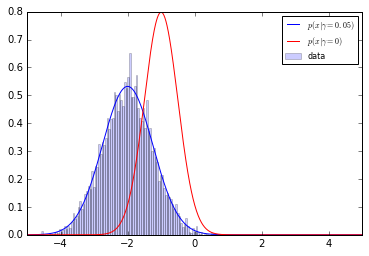

In [74]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p0.pdf(reals.reshape(-1, 1)), label=r"$p(x|\gamma=0.05)$", color="b")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label=r"$p(x|\gamma=0)$", color="r")
plt.hist(X_true[:, 0], bins=100, normed=True, label="data", alpha=0.2, color="b")
plt.xlim(-5, 5)
plt.legend(loc="best", prop={'size': 8})
#plt.savefig("fig1a.pdf")
plt.show()

In [75]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPRegressor
from carl.ratios import ClassifierRatio
from carl.ratios import DecomposedRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier

n_samples = 200000
clf = as_classifier(MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75))

p0_data = p0.rvs(n_samples // 2, random_state=1234)
p1_data = p1.rvs(n_samples // 2, random_state=1234)

X = np.vstack((p0_data, p1_data))
y = np.zeros(n_samples, dtype=np.int)
y[n_samples//2:] = 1

clf.fit(X=X, y=y)


Wrapper(base_estimator=MLPRegressor(activation='logistic', algorithm='l-bfgs', alpha=0.0001,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='constant', learning_rate_init=1e-07, max_iter=75,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, tol=1e-05, validation_fraction=0.1, verbose=False,
       warm_start=False))

In [76]:
# Calibration + Direct approximation 
#cv = StratifiedShuffleSplit(n_iter=1, test_size=0.5, random_state=1)
cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, cv='prefit', bins=20, var_width=False), 
    random_state=0)

cc_direct.fit(X=X, y=y)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=Wrapper(base_estimator=MLPRegressor(activation='logistic', algorithm='l-bfgs', alpha=0.0001,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='constan...0.1, verbose=False,
       warm_start=False)),
            bins=20, cv='prefit', method='histogram'),
        random_state=0)

-2.12801575189
0.0570568328333


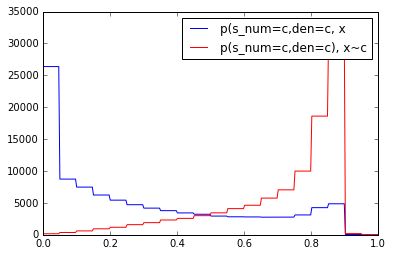

In [77]:
import carl
reals2 = np.linspace(0, 1, 100)
x = np.linspace(0.,1,300)
cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
print(cal_num.amise(biased=False))
print(cal_num.amise(biased=True))
plt.plot(x, cal_num.pdf(x.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x", c='b')
plt.plot(x, cal_den.pdf(x.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c", c='r')
plt.legend()
plt.show()

In [83]:
import carl
amises_biased_num = []
amises_unbiased_num = []
amises_biased_den = []
amises_unbiased_den = []
h_num, h_den = [],[]
#for n_bins in range(30,50,1):
for h in np.linspace(0.1,0.9,50):
    n_bins = np.ceil((X.max()-X.min())/h)
    print(str(n_bins) + ' '),
    cc_direct = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv='prefit', bins=n_bins, var_width=False), 
        random_state=0)
    cc_direct.fit(X=X, y=y)

    cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
    amises_biased_num.append(cal_num.amise(biased=True))
    amises_unbiased_num.append(cal_num.amise(biased=False))
    amises_biased_den.append(cal_den.amise(biased=True))
    amises_unbiased_den.append(cal_den.amise(biased=False))
    h_num.append(cal_num.edges_[0][2]-cal_num.edges_[0][1])
    h_den.append(cal_den.edges_[0][2]-cal_den.edges_[0][1])
    #print(cal_num.oversmoothed_bins(X[:n_samples//2]))

 70.0  61.0  53.0  47.0  43.0  39.0  36.0  33.0  31.0  29.0  27.0  26.0  24.0  23.0  22.0  21.0  20.0  19.0  18.0  18.0  17.0  16.0  16.0  15.0  15.0  14.0  14.0  13.0  13.0  13.0  12.0  12.0  12.0  11.0  11.0  11.0  11.0  10.0  10.0  10.0  10.0  10.0  9.0  9.0  9.0  9.0  9.0  9.0  8.0  8.0 


In [84]:
# Using numpu methods to estimate number of bins
methods = ['auto', 'fd', 'doane', 'scott', 'rice', 'sturges', 'sqrt']
opt_bins = []
opt_hs = []
for m in methods:
    cc_direct = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv='prefit', bins=m, var_width=False), 
        random_state=0)
    cc_direct.fit(X=X, y=y)
    cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
    opt_hs.append(cal_num.edges_[0][2]-cal_num.edges_[0][1])
    opt_bins.append(len(cal_num.edges_[0]) - 3)

Width upper bound: 122.484727045
The optimum bin width is (BCV) : 0.540816326531
The optimum number of bins is (BCV) : 13.0
The optimum bin width is (UCV) : 0.1
The optimum number of bins is (UCV) : 70.0
Numpy methods:
['auto', 'fd', 'doane', 'scott', 'rice', 'sturges', 'sqrt']
Numpy optimal widths:
[0.020408163265306121, 0.020408163265306121, 0.040000000000000001, 0.021276595744680851, 0.010752688172043012, 0.055555555555555552, 0.0031545741324921135]
Numpy optimal bins:
[49, 49, 25, 47, 93, 18, 317]


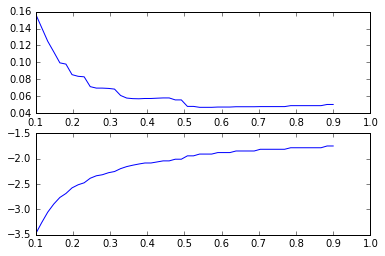

In [85]:
#print(h_num)
#xs = range(10,80,1)
hs = np.linspace(0.1,0.9,50)
plt.subplot(211)
plt.plot(hs, amises_biased_num)
plt.subplot(212)         
plt.plot(hs, amises_unbiased_num)
opt_h_bcv = hs[np.argmin(amises_biased_num)]
opt_bin_bcv = np.ceil((X.max()-X.min())/opt_h_bcv)
opt_h_ucv = hs[np.argmin(amises_unbiased_num)]
opt_bin_ucv = np.ceil((X.max()-X.min())/opt_h_ucv)
print('Width upper bound: {0}'.format(cal_num.oversmoothed_bins(X[:n_samples//2])))
print('The optimum bin width is (BCV) : {0}'.format(opt_h_bcv))
print('The optimum number of bins is (BCV) : {0}'.format(opt_bin_bcv))
print('The optimum bin width is (UCV) : {0}'.format(opt_h_ucv))
print('The optimum number of bins is (UCV) : {0}'.format(opt_bin_ucv))
print('Numpy methods:')
print(methods)
print('Numpy optimal widths:')
print(opt_hs)
print('Numpy optimal bins:')
print(opt_bins)

-2.89315952881
0.112299938408


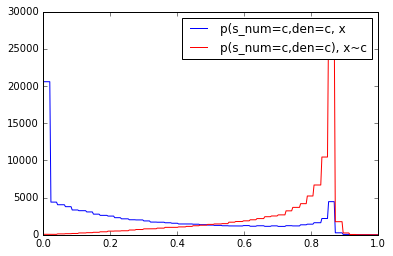

In [89]:
cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, cv='prefit', bins=47, var_width=False), 
    random_state=0)
cc_direct.fit(X=X, y=y)
cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
reals2 = np.linspace(0, 1, 100)
x = np.linspace(0.,1,300)
cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
print(cal_num.amise(biased=False))
print(cal_num.amise(biased=True))
plt.plot(x, cal_num.pdf(x.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x", c='b')
plt.plot(x, cal_den.pdf(x.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c", c='r')
plt.legend()
plt.show()